## Introduction

In this tutorial, we'll demonstrate how to leverage a pdf files sample dataset(abstracts from Computer Vision and Pattern Recognition 2019 conference) stored in Azure Cosmos DB to ground OpenAI models using `Semantic Kernel`. We'll do this by taking advantage of `Azure Cognitive Search` vector similarity search functionality. In the end, we'll create an interative chat session with the GPT-3.5 completions model to answer questions about Computer Vision and Pattern Recognition informed by our dataset. This process is known as Retrieval Augmented Generation, or RAG.

## Retrieval Augmented Generation
In retrieval augmented generation (RAG), an LLM retrieves contextual documents from an external dataset as part of its execution. 

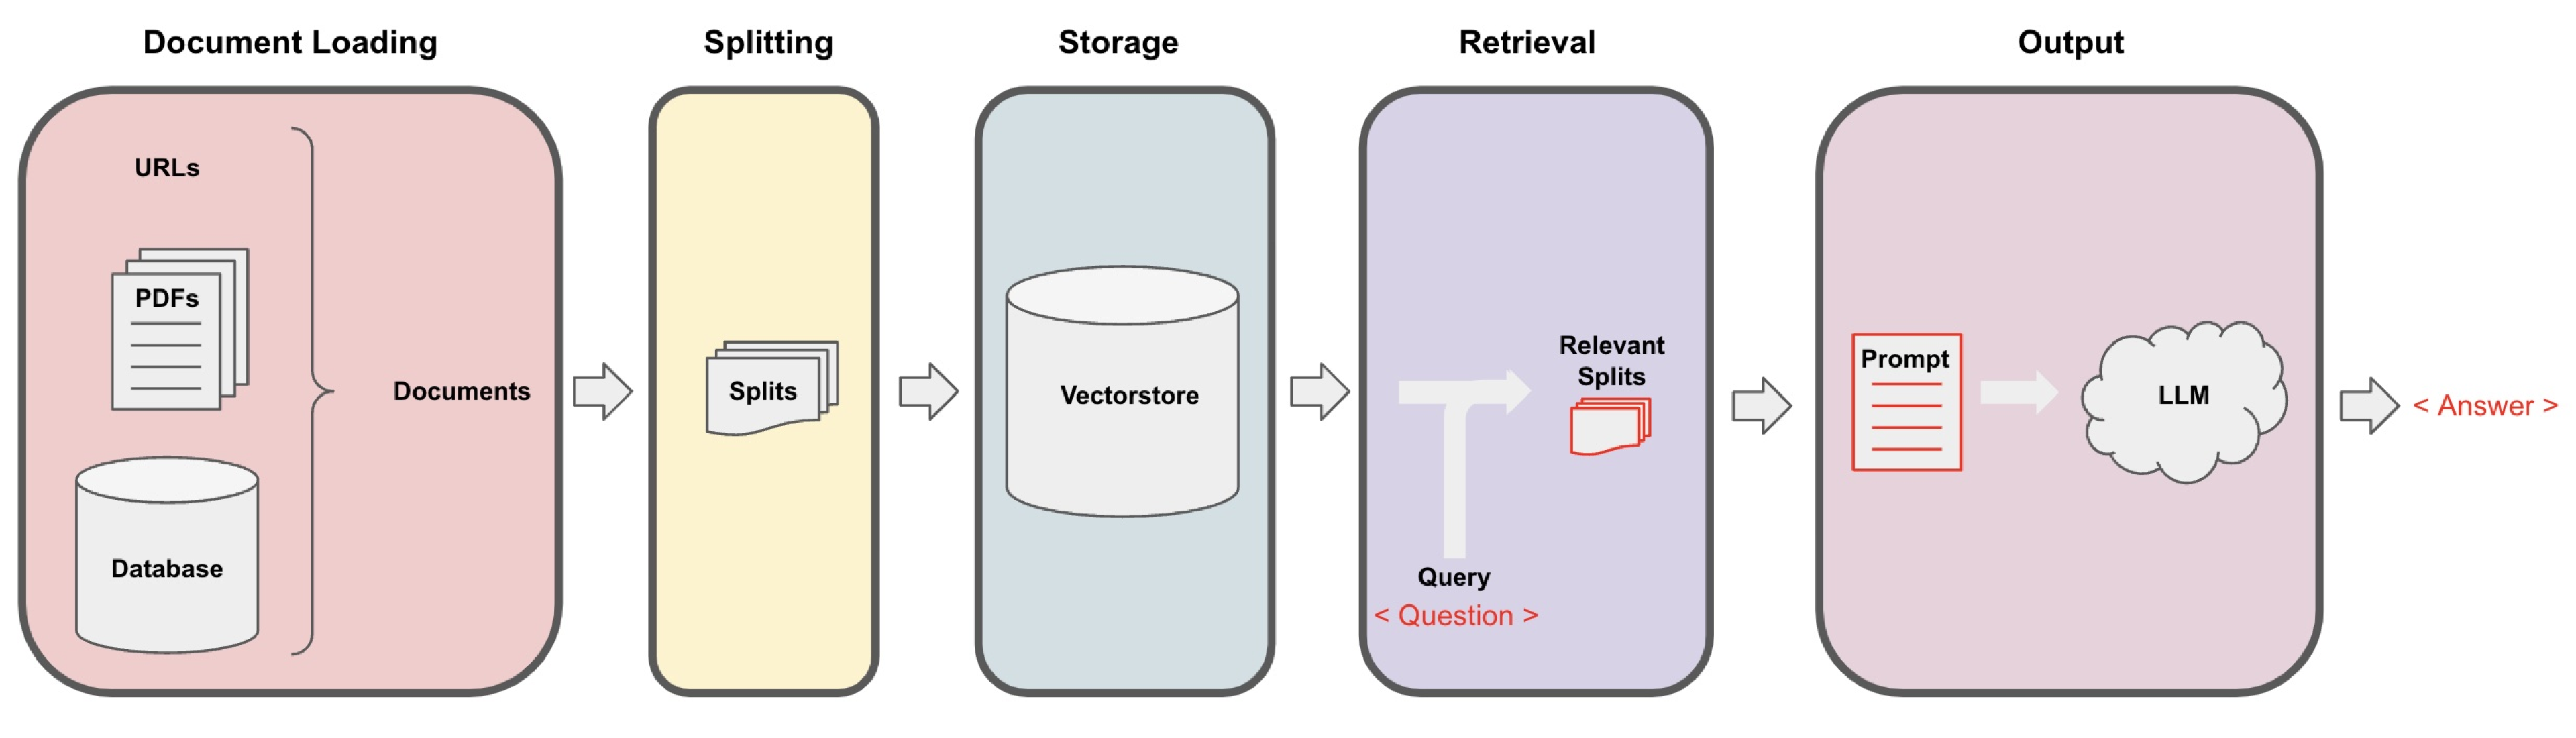

## Table of Contents
### [Step by Step Retrieval Augmented Generation](#RAG)
### [Interactive Chat Bot](#ChatBot)

## Setup

In [29]:
# ! pip install numpy
# ! pip install openai
# ! pip install python-dotenv
# ! pip install azure-core
# ! pip install azure-cosmos
# ! pip install tenacity
# ! pip install azure-search-documents==11.4.0b8
# ! pip install azure-identity
# ! pip install semantic-kernel

In [3]:
import json
import datetime
import time
import os
import asyncio
import uuid

from dotenv import dotenv_values
import openai
from random import randrange
from tenacity import retry, wait_random_exponential, stop_after_attempt
import semantic_kernel as sk
from semantic_kernel.connectors.ai.open_ai import (
    AzureTextCompletion,
    AzureTextEmbedding,
    AzureChatCompletion
)
from semantic_kernel.connectors.memory.azure_cosmosdb_no_sql import (
    AzureCosmosDBNoSQLMemoryStore,
)
# from semantic_kernel import PromptTemplateConfig, SemanticFunctionConfig, PromptTemplate
from semantic_kernel.text import text_chunker
from PyPDF2 import PdfReader

In [4]:
env_name = "cog-search.env"
config = dotenv_values(env_name)

cog_search_endpoint = config['COG_SEARCH_ENDPOINT']
cog_search_key = config['COG_SEARCH_KEY']

openai.api_type = config['OPENAI_API_TYPE']
openai.api_key = config['OPENAI_API_KEY']
openai.api_base = config['OPENAI_API_BASE']
openai.api_version = config['OPENAI_API_VERSION']
embeddings_model_deployment = config['OPENAI_EMBEDDINGS_MODEL_DEPLOYMENT']
embeddings_model_name = config['OPENAI_EMBEDDINGS_MODEL_NAME']
completions_model_deployment = config['OPENAI_COMPELETIONS_MODEL_DEPLOYMENT']
completions_model_name = config['OPENAI_COMPELETIONS_MODEL_NAME']
vector_size = 1536

## Azure OpenAI <a class="anchor" id="azureopenai"></a>

Finally, let's setup our Azure OpenAI resource Currently, access to this service is granted only by application. You can apply for access to Azure OpenAI by completing the form at https://aka.ms/oai/access. Once you have access, complete the following steps:

- Create an Azure OpenAI resource following this quickstart: https://learn.microsoft.com/azure/ai-services/openai/how-to/create-resource?pivots=web-portal
- Deploy a `completions` and `embeddings` model 
    - For more information on how to `deploy a model`, go here: https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource?pivots=web-portal#deploy-a-model
    - For more information on `completions`, go here: https://learn.microsoft.com/azure/ai-services/openai/how-to/completions
    - For more information on `embeddings`, go here: https://learn.microsoft.com/azure/ai-services/openai/how-to/embeddings
- Copy the endpoint, key, deployment names for (embeddings model, completions model) into the config.json file.

<a id='RAG'></a>

## Step by Step RAG

In [7]:
#Load
usr_dir_path = "/Users/aayushkataria/git/"
dir = usr_dir_path + "AzureDataRetrievalAugmentedGenerationSamples/Python/Pdf-Dataset/abstracts_pdf/"

# Create a dictionary of the text and source of the pdf file
documents = {}
for file in os.listdir(dir):
    pdf_path = dir + file
    pdf_file = open(pdf_path, 'rb')
    pdf_reader = PdfReader(pdf_file)
    text = pdf_reader.pages[0].extract_text()
    documents[file] = {
        'text': text,
        'source': pdf_path
    }

## Connectors

To make our kernel useful, we must link one or more AI models to enable our kernel for understanding and generating natural language. This is achieved through a connector. Semantic Kernel offers ready-to-use connectors, simplifying the addition of AI models from various sources like OpenAI, Azure OpenAI, and Hugging Face. These models are then utilized to provide a service to the kernel.

As of now, the following services are available:

-  <b>Text completion service</b>: generates natural language.
-  <b>Chat service</b>: creates a conversational experience.
-  <b>Text embedding generation service</b>: encodes natural language into embeddings.

Each service type can support multiple models from different sources simultaneously, allowing flexibility in switching between models based on tasks and user preferences. If no specific service or model is specified, the kernel defaults to the first service and model defined.

To view all currently registered services, use the following method:

In [164]:
# This list should be empty the first time you run this function, but be sure to initialize your kernel before running this.
def print_ai_services(kernel):
    print(f"Text completion services: {kernel.all_text_completion_services()}")
    print(f"Chat completion services: {kernel.all_chat_services()}")
    print(
        f"Text embedding generation services: {kernel.all_text_embedding_generation_services()}"
    )
print_ai_services(kernel)    

Text completion services: ['dv', 'chat']
Chat completion services: ['chat']
Text embedding generation services: ['ada']


In [8]:
# Setting up Azure OpenAI services for text embedding, text completion and chat completion
kernel = sk.Kernel()
kernel.add_text_embedding_generation_service(
    service_id="ada",
    service=AzureTextEmbedding(
        deployment_name=embeddings_model_deployment,
        endpoint=openai.api_base,
        api_key=openai.api_key,
    )
)

kernel.add_text_completion_service(
    service_id="dv",
    service=AzureTextCompletion(
        deployment_name=completions_model_deployment,
        endpoint=openai.api_base,
        api_key=openai.api_key,
    )
)

kernel.add_chat_service(
    service_id="chat",
    service=AzureChatCompletion(
        deployment_name=completions_model_deployment,
        endpoint=openai.api_base,
        api_key=openai.api_key
    )
)

AttributeError: 'Kernel' object has no attribute 'add_text_embedding_generation_service'

In [1]:
indexing_policy = {
    "indexingMode": "consistent",
    "includedPaths": [{"path": "/*"}],
    "excludedPaths": [{"path": '/"_etag"/?'}],
    "vectorIndexes": [{"path": "/embedding", "type": "quantizedFlat"}],
}

vector_embedding_policy = {
    "vectorEmbeddings": [
        {
            "path": "/embedding",
            "dataType": "float32",
            "distanceFunction": "cosine",
            "dimensions": 1536,
        }
    ]
}

In [2]:
from azure.cosmos import CosmosClient, PartitionKey
HOST = ""
KEY = ""

cosmos_client = CosmosClient(HOST, KEY)
database_name = "langchain_python_db"
container_name = "langchain_python_container"
partition_key = PartitionKey(path="/id")
cosmos_container_properties = {"partition_key": partition_key}

In [123]:
# Azure Cognitive Search Vector Store
azure_cog_vector_store = AzureCosmosDBNoSQLMemoryStore(
    cosmos_client=cosmos_client,
    database_name=database_name,
    partition_key=partition_key.path,
    vector_embedding_policy=vector_embedding_policy,
    indexing_policy=indexing_policy,
    cosmos_container_properties=cosmos_container_properties,
)

# Register the memory store with the kernel
kernel.register_memory_store(memory_store=azure_cog_vector_store)

In [162]:
index_name = "sk-cog-search-index-sample"

In [69]:
# Populate the PDF splits in the semantic kernel azure cognitive search memory store
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(100))
async def generate_embedding():
    for doc in documents:
        # Add documents to the ACS semantic memory
        time.sleep(0.5) # rest period to avoid rate limiting on AOAI for free tier
        await kernel.memory.save_information_async(
            collection=index_name,
            id=str(uuid.uuid4()),
            text=doc.page_content,
            description=doc.metadata.get("source")
        )

In [70]:
await generate_embedding()

hnsw_parameters is not a known attribute of class <class 'azure.search.documents.indexes._generated.models._models_py3.HnswVectorSearchAlgorithmConfiguration'> and will be ignored


In [73]:
question = "What are disadvantages of stereo cameras?"
result = await kernel.memory.search_async(index_name, question)

In [74]:
result[0].text

'Nowadays stereo cameras are more commonly adopted in emerging devices such as dual-lens smartphones and unmanned aerial vehicles. However, they also suffer from blurry images in dynamic scenes which leads to visual discomfort and hampers further image processing. Previous works have succeeded in monocular deblurring, yet there are few studies on deblurring for stereoscopic images. By exploiting the two-view nature of stereo images, we propose a novel stereo image deblurring network with Depth Awareness and View Aggregation, named DAVANet. In our proposed network, 3D scene cues from the depth and varying information from two views are incorporated, which help to remove complex spatially-varying blur in dynamic scenes. Specifically, with our proposed fusion network, we integrate the bidirectional disparities estimation and deblurring into a unified framework. Moreover, we present a large-scale multi-scene dataset for stereo deblurring, containing 20,637 blurry-sharp stereo image pairs f

In [125]:
result[0].relevance

0.8498685

<a id='ChatBot'></a>

## Chat with your data Bot

## Semantic Functions

To engage with a Large Language Model (LLM) via the Semantic Kernel, one creates a Semantic Function. This function anticipates a natural language input, employs an LLM to comprehend the inquiry, and then takes appropriate action to deliver a fitting response. For instance, a semantic function might be applied to tasks like text generation, summarization, sentiment analysis, and question answering.

Within the Semantic Kernel, a semantic function consists of two essential components:

-  <b>Prompt Template</b>: This is the natural language query or command transmitted to the LLM.
-  <b>Configuration Object</b>: This holds the settings and options for the semantic function, encompassing the service it should use, the expected parameters, and a description of its purpose.

The easiest way to commence is by utilizing the kernel's create_semantic_function method. This method takes fixed arguments like temperature and max_tokens, typically required by LLMs, and employs them to construct a configuration for us.

In [154]:
# Setting up the prompt for the chatbot, and adding history which is used to provide previous context to the chatbot.
chatbot_prompt = """
----- Chat History -----
{{$history}}
----- Current Conversation ----- 
User: {{$input}}
"""

In [155]:
chat_config_dict = {
    "schema": 1,
    # The type of prompt
    "type": "completion",
    # A description of what the semantic function does
#     "description": "A chatbot to provide information about cities and countries",
    # Specifies which model service(s) to use
    "default_services": ["chat"],
    # The parameters that will be passed to the connector and model service
    "completion": {
        "temperature": 0.0,
        "top_p": 1,
        "max_tokens": 256,
        "number_of_responses": 1,
        "presence_penalty": 0,
        "frequency_penalty": 0,
    },
    # Defines the variables that are used inside of the prompt
    "input": {
        "parameters": [
            {
                "name": "input",
                "description": "The input given by the user",
                "defaultValue": "",
            },
            {
                "name": "history",
                "description": "Previous interactions between the user and chatbot",
                "defaultValue": "",
            },
        ]
    },
}

In [156]:
# create a config which enables us to specify what we would like to use our chatbot for, 
# and combines the prompt template and the chat config in the same object.
def create_semantic_function_config(prompt_template, prompt_config_dict, kernel):
    prompt_template_config = PromptTemplateConfig.from_dict(prompt_config_dict)
    prompt_template = sk.PromptTemplate(
        template=prompt_template,
        prompt_config=prompt_template_config,
        template_engine=kernel.prompt_template_engine,
    )
    return SemanticFunctionConfig(prompt_template_config, prompt_template)

In [157]:
# create a chatbot using the config and the prompt.
function_config = create_semantic_function_config(
    chatbot_prompt, chat_config_dict, kernel
)
chatbot = kernel.register_semantic_function(
    skill_name="SimpleChatbot",
    function_name="simple_chatbot",
    function_config=function_config,
)

In [166]:
# To transmit multiple variables to our semantic function, we establish a Context object that retains the state 
# of our variables. We can create and initialize this object, including our history variable, as demonstrated below.
context = kernel.create_new_context()
context["history"] = ""

In [159]:
async def chat(question, context):
    # Save new query in the context variables
    context["input"] = question
    
    # print the full prompt before each interaction
    print("Chat with your ChatBot:")
    
    # inject the variables into our prompt
    print(await function_config.prompt_template.render_async(context))
    
    # Get the answer for the query from ACS memory
    result = await kernel.memory.search_async(index_name, question)
    text = result[0].text
    relevance_score = result[0].relevance
    
    # Show the repsonse
    print(f"ChatBot: {text}")
    
    # Append the new interaction to the chat history
    context["history"] += f"\nUser: {question}\n\nChatBot: {text}\n"

In [160]:
await chat("What are disadvantages of stereo cameras?", context)

Chat with your ChatBot:

----- Chat History -----

----- Current Conversation ----- 
User: What are disadvantages of stereo cameras?

ChatBot: Nowadays stereo cameras are more commonly adopted in emerging devices such as dual-lens smartphones and unmanned aerial vehicles. However, they also suffer from blurry images in dynamic scenes which leads to visual discomfort and hampers further image processing. Previous works have succeeded in monocular deblurring, yet there are few studies on deblurring for stereoscopic images. By exploiting the two-view nature of stereo images, we propose a novel stereo image deblurring network with Depth Awareness and View Aggregation, named DAVANet. In our proposed network, 3D scene cues from the depth and varying information from two views are incorporated, which help to remove complex spatially-varying blur in dynamic scenes. Specifically, with our proposed fusion network, we integrate the bidirectional disparities estimation and deblurring into a unifie

In [161]:
await chat("Give me some different techniques for pattern recognition", context)

Chat with your ChatBot:

----- Chat History -----

User: What are disadvantages of stereo cameras?

ChatBot: Nowadays stereo cameras are more commonly adopted in emerging devices such as dual-lens smartphones and unmanned aerial vehicles. However, they also suffer from blurry images in dynamic scenes which leads to visual discomfort and hampers further image processing. Previous works have succeeded in monocular deblurring, yet there are few studies on deblurring for stereoscopic images. By exploiting the two-view nature of stereo images, we propose a novel stereo image deblurring network with Depth Awareness and View Aggregation, named DAVANet. In our proposed network, 3D scene cues from the depth and varying information from two views are incorporated, which help to remove complex spatially-varying blur in dynamic scenes. Specifically, with our proposed fusion network, we integrate the bidirectional disparities estimation and deblurring into a unified framework. Moreover, we present 

### Some example queries for the chatbot.
1. Explain pattern recognition to me.
2. What are the advantages of using computer vision.
3. Give me some different techniques for pattern recognition.